# Noisy Label Learning

This notebook is a tutorial to show how different techniques can be used to improve classification results when learning with noisy labels. I will first explain the different types of label noise, and how we can modify classifiers, particularly deep learning models, to yield improved results on data with noisy labels. 

Run all cells in order, and make sure you have the associated file resnet18.py and loadCifar.py in the same directory to load the deep learning model architectures and data correctly.

Author: alexmarsian

Inspiration and knowledge gained from the course COMP5328 (Advanced Machine Learning) at the University of Sydney.

# Contents
1. Introduction
2. Types of label noise
3. Learning with class dependent label noise: Theory
4. Learning with class dependent label noise: Application
5. Results
6. Conclusion

# Imports

In [4]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.neural_network import MLPClassifier
from sklearn import datasets
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from loadCifar import reduced_cifar
from resnet18 import ResNet18
from pathlib import Path
import time
import pandas as pd

# 1. Introduction

In classification problems, if any of the data points are not correctly labelled, then the data set contains noisy labels. In most of the benchmark data sets, a low level of label noise is actually present, with this paper https://arxiv.org/abs/2103.14749 finding that at least 6% of the images in ImageNet are erroneously labeled. 


Notably, the presence of label noise can skew our perception of model performance. When comparing models on benchmark classification data sets with noisy labels, it is hard to separate whether one model is better at classification, or simply better at dealing with label noise. 

## 1.1 Label Noise Example

Here I generate some sample binary classification data, and then corrupt a small fraction of the labels for each class to show the effect of training with label noise on a simple linear model. This process is wrapped in a function to allow for experimentation with sample size, and noise rates.

In [5]:
def generate_binary_data(sampleSize):
    """
    Generates a sample binary classification data set of size = sampleSize.
    """
    # Generate some 2D binary data
    x1 = np.random.random(sampleSize)*10 
    x2 = np.random.random(sampleSize)*10 
    X = np.array((x1,x2)).T
    y = np.array([1 if x2 > x1 else 0 for x2, x1 in zip(list(x1), list(x2))]) # labels are 0 or 1

    # Create training and test sets with 80/20 split
    idx = int(0.8*sampleSize)
    XTrain = X[:idx]
    XTest = X[idx:]
    YTrain = y[:idx]
    YTest = y[idx:]
    
    return XTrain, XTest, YTrain, YTest

def corrupt_Y(Y, noiseRate):
    """
    Corrupts a binary label based on the noise rate, assuming random classification noise model.
    """
    # Corrupt some of the labels
    # this loop will flip 10% of the 1s to 0s and 10% of 0s to 1s
    YTrainCorrupt = []
    for yi in Y:
        if (yi == 1 and np.random.random(1) > 1-noiseRate):
            YTrainCorrupt.append(0)
        elif (yi == 0 and np.random.random(1) > 1-noiseRate):
            YTrainCorrupt.append(1)
        else:
            YTrainCorrupt.append(yi)
            
    return YTrainCorrupt


def plot_noisy_regression(sampleSize, noiseRate, plotTest = True, plotNoisy=False):
    """
    Plots the regression on clean data, compared to the regression on noisy data, 
    over the points in the test set. 
    """
    # Create a sample data set
    XTrain, XTest, YTrain, YTest = generate_binary_data(sampleSize)
    # Create a noisy label set
    YTrainCorrupt = corrupt_Y(YTrain, noiseRate)

    def get_logreg_params(X, y):
        """
        Function to compute logistic regression parameters given features X and labels y.
        """

        # Fit logistic regression models to the clean and corrupted data
        clf = sklearn.linear_model.LogisticRegression()
        clf.fit(X, y)

        # Retrieve the model parameters.
        b = clf.intercept_[0]
        w1, w2 = clf.coef_.T
        # Calculate the intercept and gradient of the decision boundary.
        c = -b/w2
        m = -w1/w2

        return c, m


    c, m = get_logreg_params(XTrain, YTrain)
    cCorrupt, mCorrupt = get_logreg_params(XTrain, YTrainCorrupt)
    
    # Create plot
    matplotlib.rcParams.update({'font.size': 16})
    
    if plotTest:
        plotDat = XTest
        plotCol = YTest
    elif plotNoisy:
        plotDat = XTrain
        plotCol = YTrainCorrupt
        

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    # Compare regression on clean and corrupted data
    xd = np.array([0, 10])
    yd = m*xd + c
    ydCorr = mCorrupt*xd + cCorrupt
    ax.scatter(plotDat.T[0], plotDat.T[1], c=plotCol, alpha=0.5)
    ax.plot(xd, yd, c='blue', lw=1, label='clean')
    ax.plot(xd, ydCorr, c = 'red', lw=1, label='noisy')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.legend(loc="upper left")
    plt.show()

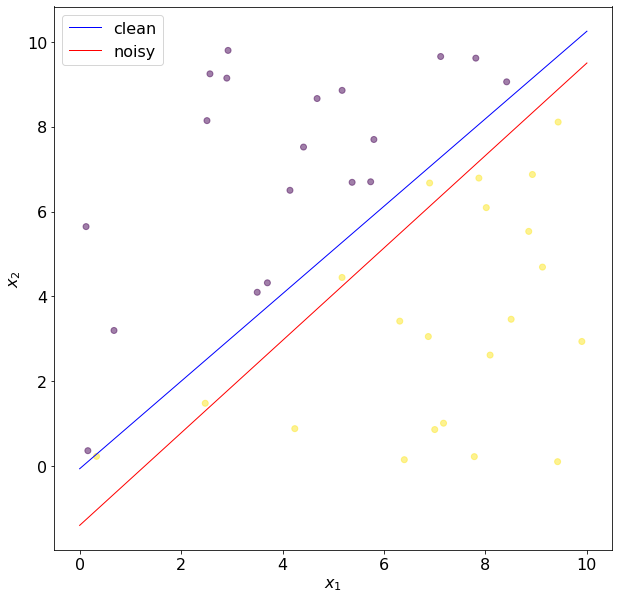

In [6]:
plot_noisy_regression(200, 0.2)

We can see there are a number of misclassified points when the regression is trained on data with noisy labels. Here the flip rate for each class is 20%, but it doesn't need to be the same for each class, nor does it need to be class dependent. In the next section I will explain the different types of label nosie from a statistical perspective. 

# 2. Types of Label Noise

In the label noise problem, we assume that our test set or new data are drawn from a clean distribution $D(X,Y)$, whilst the training set is drawn from a noisy distribution $D_\rho(X,\hat{Y})$, where $\hat{Y}\in Y$ is an observable but noisy label. This is the scenario in the above regression example.

Given training examples ${X_i, \hat{Y}_i}$ drawn from $D_\rho$, the aim is to learn a classifier that can assign clean labels $Y_j$ to new data points $X_j$.

Consider a binary classification problem where $Y\in {-1, 1}$, then we set up a probabilistic model $$\rho_Y(X)=P(\hat{Y}|X,Y),$$
which is the probability that the clean label for an observation will flip to being noisy. I.e. the probability that a $1$ flips to a $-1$, or $-1$ to a $1$.

Then we have $\rho_{+1}(X)=P(\hat{Y}=-1|Y=1,X)$, and $\rho_{-1}(X)=P(\hat{Y}=+1|Y=-1,X)$. 

So without noisy labels the model states that $$P(\hat{Y}=1|Y=1,X)=P(\hat{Y}=-1|Y=-1,X)=1.$$

Now let's examine some specific formulations of label noise, and how they can be dealt with.

## 2.1 Random Classification Noise

In the case of random classification noise (RCN), we have $\rho_Y(X)=P(\hat{Y}|Y,X)=P(\hat{Y}|Y)$, meaning that the flip rates are independent of the instance $X$. Furthermore, $\rho_{+1}=\rho_{-1}=\rho$, meaning the flip rates for each class are identical, or independent of the class. 

In this paper: https://link.springer.com/article/10.1007/s10994-009-5165-z, they show that any linear classifier can degrade to random guessing under RCN. However, in this paper: https://arxiv.org/abs/1403.3610, they show that any symetric loss function is robust to RCN when the function class is universal. In practise this means that with enough noisy data, a symetric loss function, and a function that approximates the universal function space, a model learned on noisy data can approximate the model that would be learned on clean data. 

### 2.1.1 Learning with Random Classification Noise

In the initial regression example, the noise implemented was RCN, as the flip rate for each class was identical. With a larger sample size, and neural network (universal function approximator), we could expect the model trained on noisy data to achieve similar performance to a model trained on clean data.

Here we can use Scikit-learns multi-layer perceptron model as a universal function approximator to apply the results from the above two papers:

In [7]:
sampleSize = 20000 # with larger sample size, you may need to adjust max_iter too
hiddenLayerSize = 100 # more parameters & layers means the universal function class is better approximated
noiseRate = 0.4 # between 0 and 1
max_iter = 300

# Generate sample data
XTrain, XTest, YTrain, YTest = generate_binary_data(sampleSize)
# Corrupt some samples
YTrainCorrupt = corrupt_Y(YTrain, noiseRate)
# Create MLP Classifiers
clean_clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(hiddenLayerSize, 2), max_iter=max_iter) 
noisy_clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(hiddenLayerSize, 2), max_iter=max_iter)
clean_clf.fit(XTrain, YTrain)
noisy_clf.fit(XTrain, YTrainCorrupt)

# make predictions and print accuracy on test set
print(f"Accuracy of classifier trained on clean data : {clean_clf.score(XTest, YTest)*100}%")
print(f"Accuracy of classifier trained on noisy data: {noisy_clf.score(XTest, YTest)*100}%")

Accuracy of classifier trained on clean data : 48.875%
Accuracy of classifier trained on noisy data: 99.0%


So with a neural network and symetric loss function, we can easily train classifiers to cope with RCN! Thus if you know your data set has RCN, it shouldn't be too difficult to build a robust classifier, provided you have a large data set. Try playing with the sampleSize, hiddenLayers, and noiseRate to see how the results vary.

## 2.2 Class Dependent Label Noise



For class conditional noise (CCN), we have $\rho_Y=P(\hat{Y}|Y,X)=P(\hat{Y}|Y)$, meaning the noise is also independent from the instance. However, $$\rho_{+1}(X)=\rho_{+1};\rho_{-1}(X)=\rho_{-1},$$meaning that the flip rate is dependent on the class. In other words, labels from the same class have the same probability of flipping. 

For a 3 class problem, we would have 6 different flip rates $\rho_i$, as for each class, we have two flip rates of that class being labelled as one of the other two. 

CCN is common, as normally there are some classes which are harder to distinguish than others, which can lead to mislabelling in the data gathering process. For example, consider the MNIST data set shown below:

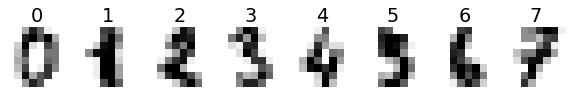

In [8]:
# Load and display some digits from MNIST
digits = datasets.load_digits()
_, axes = plt.subplots(nrows=1, ncols=8, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

We could imagine that the digits $1$ and $7$ are more likely to be confused than the digits $1$ and $0$, which would be a case of class dependent label noise.



Dealing with CCN is more complex than RCN, and there are a number of approaches to deal with CCN. Thus, the rest of this tutorial will focus on methods for CCN, which are explored in section 3. 

## 2.3 Instance and Class Dependent Label Noise

In the case of instance and class dependent label noise, we have $$\rho_Y(X)=P(\hat{Y}|Y,X),$$ meaning that for different instances, the labels have different probabilities of being noisy. 

Handling this kind of label noise is an ongoing area of research, however a recent paper: https://proceedings.neurips.cc/paper/2020/file/5607fe8879e4fd269e88387e8cb30b7e-Paper.pdf, has shown that combining methods for dealing with CCN and a parts-based learning approach can effectively deal with instance and class dependent label noise. 

At a later stage, I plan to implement this paper and other approaches to learning with instance dependent label noise.

# 3 Learning with Class Dependent Label Noise: Theory

## 3.1 Bespoke Approaches

It is worth mentioning that one can attempt to deal with CCN manually, either by correcting incorrectly labelled images, or by identifying a subset of incorrectly images, and using this subset to build a classifier for identifying other incorrectly labelled images. However, these approaches do not scale well, and do not allow for online learning.

## 3.2 Statistical Approaches

The goal of statistical approaches is to adjust the loss function $L$ to a loss $\tilde{L}$ such that $$arg\min_{f\in F} R_{D,L}(f)=arg\min_{f\in F}R_{D_\rho, \tilde{L}}(f).$$ This means we want minimisation over the loss $\tilde{L}$ on noisy data $D_\rho$, to yield the same function $f$ as would be learned by minimising the loss $L$ learned on clean data $D$. 

### 3.2.1 Importance Reweighting


Importance reweighting is a technique that was first introduced for transfer learning in https://ieeexplore.ieee.org/document/4803844 and http://www.gatsby.ucl.ac.uk/~gretton/papers/covariateShiftChapter.pdf, and was subsequently employed for learning with CCN in https://arxiv.org/pdf/1411.7718.pdf. 

Through importance reweighting, we can achieve theoretical guarantees of robust learning under CCN. I will go through the proof of importance reweighting here, as presented in https://arxiv.org/pdf/1411.7718.pdf. For more detail please see the paper.

We have $R_{D,L}(f)$, which can be written as the expected value of the loss $L$ over the data:
$$
R_{D,L}(f)=\mathbb{E}_{(X,Y)~D}[L(f(X),Y)],
$$ which can be written as $\int P_D (X,Y) L(f(X),Y)dXdY$ by the definition of the expected value. 

Now the technique of importance reweighting can be employed:

\begin{equation}
\begin{split}
\int P_D (X,Y) L(f(X),Y)dXdY &= \int P_{D_\rho} (X,Y) \frac{P_D(X,Y)}{P_{D_\rho}(X,Y)} L(f(X),Y) dX dY \\
&= \mathbb{E}_{(X,Y)~D_\rho}[\frac{P_D(X,Y)}{P_{D_\rho}(X,Y)} L(f(X),Y)] \\
&= \mathbb{E}_{(X,Y)~D_\rho}[\beta(X,Y) L(f(X),Y)],
\end{split}
\end{equation}
where $\beta(X,Y)=\frac{P_D(X=x,Y=y)}{P_{D_\rho}(X=x,\hat{Y}=y)}$.

Here, $\beta(X,Y)$ can be re-written as $\beta(X,Y)=\frac{P_D(Y=y|X=x)}{P_{D_\rho}(\hat{Y}=y|X=x)}$ as $P(X)$ cancels. Then in the paper they state that $\beta(X,Y)$ can be further re-written as
$$
\beta(X,Y) = \frac{P_{D_\rho}(\hat{Y}=y|X=x)-\rho_{-y}}{(1-\rho_{+1}-\rho_{-1})P_{D_\rho}(\hat{Y}-y|X=x)}
$$

Now to learn the new loss function, we need to know the conditional probability of the noisy labels $P_{D_\rho}(\hat{Y}|X)$, and the flip rates $\rho$. 

#### 3.2.1.1 Conditional Probability Estimation

In the paper, they explore methods using kernel density estimation and the density ratio estimation method to learn $P(\hat{Y}|X)$. This is because at the time, large deep learning models were more costly, and less powerful, and subsequently estimating $P(\hat{Y}|X)$ using a probabilistic classifier would have introduced an assumption on the target distribution $P_{D_\rho}(\hat{Y}|X)$. 

For example, as stated in the paper using the logistic loss function with a classifier would yield the assumption that
$$
P_{D_\rho}(\hat{Y}|X,f)=\frac{1}{1+exp(-\hat{Y}f(X))},
$$

which is only appropriate when logistic regression is actually in the same hypothesis class as the target function. 

Thus, using a deep neural network (DNN) can mitigate this effect by being an approximation of the universal function class. By using a DNN therefore, we can learn the conditional probality $P_{D_\rho}(\hat{Y}|X)$ from the noisy data training data. 

#### 3.2.1.2 Noise Rate Estimation

In https://arxiv.org/pdf/1411.7718.pdf, they introduce the anchor point assumption to efficiently estimate noise rates in a data set. The anchor point assumption is that the noisy data must contain perfect examples, i.e. instances whose probability of being misclassified is 0. 

Formally, an example $x^i\in X$ is an anchor point for the $i$-th class of $Y$ if $P(Y_i|x^i)=1$.

Now the usefulness of the anchor point assumption relies on understanding the relationship between CCN and the noisy class posterior. The following proof is also used when re-formulating $\beta(X,Y)$ in the importance reweighting technique. 

We start with considering $P(\hat{Y}=1|X)$, and re-write it in terms of the flip rates for each class:
\begin{equation}
\begin{split}
P(\hat{Y}=1|X) &= P(\hat{Y}=1,Y=1|X)+P(\hat{Y}=1,Y=-1|X) \text{ (using the sum rule) } \\
&= P(\hat{Y}|Y=1,X)P(Y=1|X) + P(\hat{Y}=1|Y=-1,X)P(y=-1|X) \text{ (law of conditional probablity) } \\
&= (1- \rho_{+1})P(Y=1|X)+\rho_{-1}P(Y=-1|X) \text{ (using the product rule) } \\
&= (1-\rho_{+1} - \rho_{-1})P(Y=1|X) + \rho_{-1} \text{ (using the complement rule and factorising) } \\
\end{split}
\end{equation}

This proof can be replicated for $P(\hat{Y}=-1|X)$ to yield 
$$
P(\hat{Y}=-1|X) = (1-\rho_{+1} - \rho_{-1})P(Y=-1|X) + \rho_{+1}
$$

Now for a binary classification problem we want to estimate the flip rate of labels from $+1$ to $-1$ and vice versa, so we examine:
\begin{equation}
\begin{split}
P(\hat{Y}=-1|X=x_{+1}) &= (1-\rho_{+1} - \rho_{-1})P(Y=-1|X=x_{+1}) + \rho_{+1} \text{ (instance with pos label flips to negative) } \\
P(\hat{Y}=+1|X=x_{-1}) &= (1-\rho_{+1} - \rho_{-1})P(Y=+1|X=x_{1}) + \rho_{-1} \text{ (instance with neg label flips to positive) } \\
\end{split}
\end{equation}

Now we assume that both $x_{+1}$ and $x_{-1}$ are anchor points, meaning both $P(Y=-1|X=x_{+1})$ and $P(Y=+1|X=x_{-1})$ are equal to 0. This leaves us with 
$$
\begin{equation}
\begin{split}
P(\hat{Y}=-1|X=x_{+1})&=\rho_{+1} \\
P(\hat{Y}=+1|X=x_{-1})&=\rho_{-1} 
\end{split}
\end{equation}
$$

The final assumption is that the flip rates are small such that $\rho_{+1} + \rho_{-1} \le 1$, and which means we can use the minimum value of the noisy class posterior to estimate $\rho$ for each class. Furthermore, it is assumed that the chance of flipping from the positive class to the negative class, is less than the negative noisy class posterior (and vice versa). 

### 3.2.2 Applying Importance Reweighting: Transition Matrix Estimation

Now to extend the importance reweighting technique to multi-class problems, we can use transition matrix estimation. This approach was introduced in https://arxiv.org/abs/1609.03683. The goal is to build a transition matrix $T$ such that
$$
P(\hat{Y}|x^i)=\sum^c_k P(\hat{Y}|Y=k, x^i)P(Y=k| x^i)=P(\hat{Y}=j|Y=i, x)=T_{ij},
$$

This holds from the anchor point assumption as $P(Y=k|x^i)=1$ when $k=i$ and is equal to $0$ otherwise. This also relies on the assumption of class conditional noise, where $P (\tilde{Y} = i| Y = j, X) = (\tilde{Y} = i| Y = j)$ as the flip rate is assumed to be instance-independent. 

The output of a softmax function $\hat{x}^i=\arg\max_{x\in X}, P(\hat{Y}=i|X)$ is then used to find $T_{ij}=P(\hat{Y}=j|\hat{x}^i)$.

The paper then describe two methods for using the transition matrix, namely the forward and backward learning algorithms. 

In the backward learning algorithm, for some loss function $l(P(Y|X)$, a backward corrected loss is given by $T^{-1}l(P(Y|X))$, yielding an unbiased loss correction. However, there is no guarantee that the transition matrix $T$ is invertible. 

In the forward learning algorithm, the loss function becomes dependent on $T$ so that a network learns the clean class posterior multiplied by $T$. Here is a reproduction of the example for cross-entropy given in the paper. In cross-entropy the loss function is given by 
\begin{equation}
    \begin{split}
        l(i, P(Y|X)) &= -\log P(\hat{Y}=i|X) \\
        &= -\log \sum^c_{j=1} P(\hat{Y}=i|Y=j)P(Y=j|X)\\
        &= -\log \sum^c_{j=1} T_{ij} P(Y=j|x)
    \end{split}
\end{equation}

The main drawback of this approach is that it assumes we have known anchor points, with a posterior probability close to $1$. Thus in the paper, they show that using points with posterior probability above 97% yields accurate transition matrices. That is the approach I will use here. 

Now we can implement this concept, assuming we use a softmax function in Pytorch:

In [9]:
def get_probs(model, dataloader, device):
    """
    Applies a softmax function over all batches of a dataloader to 
    generate the probabilities for transition matrix estimation.
    """
    probs = []
    with torch.no_grad():
        model.train()
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            logits = model(batch_x)
            p = F.softmax(logits, 1)
            probs.append(p.clone().detach().cpu().numpy())

    probs = np.concatenate(probs, 0)
    return probs

def get_transition_anchor(probs, alpha=0.3):
    """
    Given outputs of softmax applied to batches, 
    returns an estimate of the transition matrix
    """
    n_class = probs.shape[1]
    anchor_probs = np.quantile(probs, 1-alpha, axis=0, interpolation='higher')

    T = np.zeros((n_class, n_class))
    for i in range(n_class):
        idx = np.nonzero(probs[:,i] == anchor_probs[i])[0][0]
        T[i,:] = probs[idx,:]

    return T

### 3.2.3 Robust Loss Functions

A number of loss functions have been proposed in order to reduce the impact of label noise. I implement a few for use with PyTorch to draw comparisons against the transition matrix estimation method.

#### 3.2.3.1 Mean Absolute Error

Mean absolute error was first proprosed as a robust loss function in https://arxiv.org/abs/1712.09482. 

If the class of $x$ is $j$ then $y$ is given as a one hot encoded vector $e_j$ where $e_{ji} = 1$ if $i = j$, otherwise 0. From this definition of one hot encoding, we can define the mean absolute error (MAE) as

\begin{equation}
    l_{mae} = ||e_j - f(x)||_1  
\end{equation}
where $||\cdot||_1$ is the $L_1$-norm and is defined as $\sum |\cdot|$. As explained in the paper, the MAE is theoretically robust to noise, but tends to under fit. However, it is simple to implement and serves as a sound baseline to compare other robust loss functions against.

In [10]:
# Pytorch Implementation
class MAE(torch.nn.Module):
    def __init__(self, beta=1.0):
        super(MAE, self).__init__()
        self.beta = beta
        return

    def forward(self, pred, labels):
        # softmax and log has already been applied to pred
        pred = pred.exp()
        one_hot = torch.nn.functional.one_hot(labels, 3).float().to(device)
        mae = torch.abs(pred - one_hot).sum(dim=1)
        return self.beta * mae.mean()

#### 3.2.3.2 Generalised Cross-Entropy

Generalised Cross-Entropy (GCE) was introduced in https://arxiv.org/abs/1805.07836.

The GCE is a truncated version of the negative Box-Cox transformation, which is defined as 
\begin{equation}
    L_q(f(x), j)=\frac{(1-f_j(x)^q)}{q},
\end{equation}
where $q \in (0, 1]$. As $q\rightarrow0$, the $L_q$ loss is equivalent to cross-entropy, and when $q=1$, it becomes the MAE \cite{gce}. They introduce a truncated $L_q$ loss defined as 
\begin{equation}
    L_{trunc}(f(x), j)=
    \begin{cases}
    L_q(k) &\text{ if } f_j(x)\le k \\
    L_q(f(x), j) &\text{ if } f_j(x)> k,
    \end{cases}
\end{equation}
where $0<k<1$ and $L_q(k)=\frac{1-k^q}{q}$. This introduces a hyper parameter $k$ that must be tuned based on the noise level in the data set. This is because if the softmax output for a label $j$ is below the threshold $k$, then the loss value is a constant value, and therefore has a gradient of zero. A larger $k$ value thus creates tighter bounds on the function, and indicates improved robustness to noise. However, during the early training stage the value $k$ may be too stringent and discard a mixture of clean and noisy labels. To remedy this, they propose another method which requires an alternative convex search algorithm, which is computationally intensive and thus was not implemented here. 

In [11]:
# Pytorch Implementation
class GCE(torch.nn.Module):
    def __init__(self, k=0.7):
        super(GCE, self).__init__()
        self.k = k

    def forward(self, pred, labels):
        # softmax and log has already been applied to pred
        pred = pred.exp()
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        one_hot = torch.nn.functional.one_hot(labels, 3).float().to(device)
        gce = (1. - torch.pow(torch.sum(one_hot * pred, dim=1), self.k)) / self.k
        return gce.mean()

#### Active Passive Losses

A recent framework for creating label noise robust loss functions was proposed in https://arxiv.org/abs/2006.13554.

They define an active loss as one that only maximises $P(Y=i|x)=1$ where $i$ is a class in $Y$, otherwise it is passive. For example, in cross-entropy, the probability $P(Y=i|x)=1$ is maximised, making it an active loss. Whilst MAE minimises the probabilities for all $Y\ne i$ along with maximising the probability $Y=i$. An active passive loss (APL) is then simply the combination of the two, defined as $L_{APL} = L_{active}+L_{passive}$. Notably, the APL approach can overcome the difficulty of optimising robust loss functions. Thus, here I implemented a single active passive loss by combining the GCE loss, with the mean absolute error. This is because the GCE loss is active, whilst the MAE is passive. Importantly, the weight of each loss should be scaled, so that the final equation for a $GCE + MAE$ loss would be 
\begin{equation}
    L_{APL} = \alpha L_{GCE}+\beta L_{MAE}
\end{equation}
where $\alpha$ and $\beta$ are tuning parameters that should be determined for a specific APL on a specific data set. To avoid tuning these parameters, I used the settings described in the paper for combining cross entropy and MAE on the MNIST data set, where $\alpha=1$ and $\beta=100$.

In [12]:
# Pytorch Implementation
class GCEplusMAE(torch.nn.Module):
    def __init__(self, beta, k=0.7):
        super(GCEplusMAE, self).__init__()
        self.gce = GCE(k=k)
        self.mae = MAE(beta=beta)

    def forward(self, pred, labels):
        return self.gce(pred, labels) + self.mae(pred, labels)

# 4. Learning With Class Dependent Label Noise: Application

Now we can try applying these methods! Here is the plan:
1. Load a multi-class classification data set
2. Flip some labels (make the data set noisy)
3. Define a deep neural network architecture
4. Train and Evaluate the network using a transition matrix, and the robust loss functions
5. Compare the results

## 4.1 Loading the CIFAR10 Data

We can load CIFAR10 directly from PyTorch. Pixel values are already in the range [0,1] when loaded:

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor()])

# download training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [14]:
# download testing set 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


To simplify the problem for this tutorial, we will remove all but 3 classes from CIFAR10. Since this is still a multiclass classification problem, the results should be easily applicable to problems with more classes. 

In [15]:
# randomly pick three classes to keep
toKeep = random.sample(range(0, 9), 3)
# retain 3 classes in training set
keepIDxs = [i for i,l in zip(range(len(trainset.targets)), trainset.targets) if l in toKeep]
images = np.array(trainset.data)[keepIDxs]
labels = np.array(trainset.targets)[keepIDxs]
# retain 3 classes in test set
keepIDxs = [i for i,l in zip(range(len(testset.targets)), testset.targets) if l in toKeep]
testImages = np.array(testset.data)[keepIDxs]
testLabels = np.array(testset.targets)[keepIDxs]

In [16]:
# relabel as 0-2 for three classes
labelMap = {k:v for k,v in zip(np.unique(labels), range(len(np.unique(labels))))}
labels = np.vectorize(labelMap.get)(labels)
testLabels = np.vectorize(labelMap.get)(testLabels)

In [17]:
# Create a test dataloader for use later
batch_size = 32
reduced_testset = reduced_cifar(testImages, testLabels)
test_loader = torch.utils.data.DataLoader(reduced_testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Now let's display some of the images

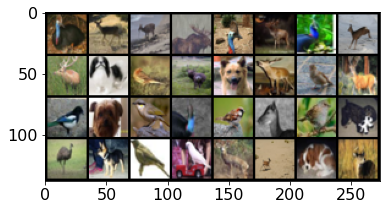

In [18]:
# function to convert images from torch to np for matplotlib
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get a batch of images
reduced_trainset = reduced_cifar(images, labels) # see loadCifar.py for the PyTorch class definition
trainloader = torch.utils.data.DataLoader(reduced_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
dataiter = iter(trainloader)
imSample, labSample = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(imSample))

So we can see there are only three classes present, Dog, Bird, and Ship.

## 4.2 Flipping Labels

Now we can flip labels in the training set according to a transition matrix. If we define the matrix here, we can check how well our transition matrix estimation has been. 

In [19]:
def createTransitionMatrix(y, noise):
    """
    Creates a random symmetric transition matrix given the labels y (no need to specify # classes)
    """
    numClasses = len(np.unique(y))
    T = np.ones((numClasses, numClasses))
    T = (noise / (numClasses - 1)) * T
    if noise > 0.0:
        T[0,0] = 1. -  noise
        for i in range(1, numClasses-1):
            T[i, i] = 1. - noise
        T[numClasses-1, numClasses-1] = 1. - noise
    return T

In [20]:
def applyTransitionMatrix(y, noise, random_state=0):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.
    """
    # Generate transition matrix
    T = createTransitionMatrix(y, noise)
    
    #print np.max(y), P.shape[0]
    #assert T.shape[0] == T.shape[1]
    #assert np.max(y) < T.shape[0]

    # row stochastic matrix
    #assert_array_almost_equal(T.sum(axis=1), np.ones(T.shape[1]))
    #assert (T >= 0.0).all()

    m = y.shape[0]
    #print m
    new_y = y.copy()
    flipper = np.random.RandomState(random_state)

    for idx in np.arange(m):
        i = y[idx]
        # draw a vector with only an 1
        flipped = flipper.multinomial(1, T[i, :], 1)[0]
        new_y[idx] = np.where(flipped == 1)[0]

    return new_y

Now let's create a transition matrix and view it

In [21]:
T = createTransitionMatrix(labels, 0.4)
print(T)

[[0.6 0.2 0.2]
 [0.2 0.6 0.2]
 [0.2 0.2 0.6]]


In [22]:
noisy_labels = applyTransitionMatrix(labels, 0.4)

Calculate the percentage of total flipped labels (this number should be very similar to 1 - rate specified in the transition matrix):

In [23]:
print(f'{(sum(noisy_labels != labels)/len(labels))*100}% of labels flipped')

39.666666666666664% of labels flipped


When we estimate the transition matrix, we can compare it with the one generated here by calculating the estimation error:

In [24]:
def t_est_error(T, T_true):
    error = np.sum(np.abs(T-T_true)) / np.sum(np.abs(T_true))
    return error

## 4.3 Deep Neural Network

For this problem, I am using ResNet18, first described in https://arxiv.org/abs/1512.03385. As we only have 3 image classes, this simple convolutional neural network should suffice, and be faster to train than more complex CNNs.

For the resnet definition, please see resnet.py, as PyTorch struggles to find class definitions in jupyter notebooks unless defined in the same cell. 

In [25]:
# function to load the model and initialise an optimiser
def get_model(lr=0.001):
    model = ResNet18(3)
    optimizer = optim.Adam(model.parameters(), lr=lr)
        
    return model, optimizer

## 4.4 Training and Evaluation

For the training and evaluation of different models, I am going to use 3-fold cross-validation with an 80/20 split. Here I define the functions to construct the training process:
1. For 3-folds: 
2. Generate Training and Validation Sets
3. Estimate Transition Matrix (if using transition matrix) 
4. Train the model and Save Best Models
5. Evaluate the best models on the test set

### 4.4.1 Functions to Generate Splits

In [26]:
def split(noisy_images, noisy_labels, train_split=0.8, seed=1):
    N = len(noisy_labels)
    index = np.arange(N)
    if seed is not None:
        r = np.random.RandomState(seed)
        r.shuffle(index)
    else:
        np.random.shuffle(index)
    train_idx, val_idx = index[:int(train_split * N)], index[int(train_split * N):]
    
    train_images, train_labels = noisy_images[train_idx], noisy_labels[train_idx]
    val_images, val_labels = noisy_images[val_idx], noisy_labels[val_idx]
    
    return train_images, train_labels, val_images, val_labels

In [27]:
def make_valid_split(images, labels):
    """
    Creates an 80% training set and 20% validation set for 10-fold validation.
    """
    # Split data 
    train_images, train_labels, val_images, val_labels = split(images, labels, train_split=0.8, seed = None)
    
    # Create Pytorch Dataset for use with Dataloader 
    train_set = reduced_cifar(train_images, train_labels)
    val_set = reduced_cifar(val_images, val_labels)

    # Create Dataloaders
    train_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True, num_workers=0, drop_last=False)
    val_loader = DataLoader(dataset=val_set, batch_size=128, shuffle=False, num_workers=0, drop_last=False)
    
    n = len(train_set)
    
    return train_loader, val_loader, n

### 4.1.2 Function to Estimate Transition Matrix

In [28]:
def get_trans_matrix(epochs_est, train_loader, val_loader, n, device, model, optimizer, run):
    """
    Returns the transition matrix with alpha cutoff 0.03. 
    """
    
    print(f'Starting run {run+1} of Transition matrix estimation')

    # Train noisy posterior to estimate T
    epochs_est = 5

    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    best_epoch, best_val_loss = 0, np.inf

    for epoch in range(epochs_est):
        print("Epoch: {}".format(epoch+1))

        train_loss, train_acc = train(model, optimizer, train_loader, device)
        train_loss /= n
        print("Train Loss: {:.6f}, Acc: {:.6f}".format(train_loss, train_acc))

        val_loss, val_acc = evaluate(model, val_loader, device)
        print("Val Loss: {:.6f},  Acc: {:.6f}".format(val_loss, val_acc))
        
        # save the model with best validation loss
        if val_loss < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/best_model_est.pkl')

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    
    # estimate the transition matrix
    model.load_state_dict(torch.load('models/best_model_est.pkl', map_location=device)) # load the best model from transition matrix estimation
    probs = get_probs(model, train_loader, device)
    

    print(f'Finished run {run+1} of Transition matrix estimation')
    
    # return the transition matrix
    est_T_alpha = get_transition_anchor(probs, alpha=0.03) # using 97th percentile
    return est_T_alpha

### 4.1.3 Function to Train Model

In [29]:
def train(model, optimizer, data_loader, device, t=None, loss_criterion=F.nll_loss):
    train_loss = 0.
    train_acc = 0
    N = 0
    
    model.train()    
    for batch_x, batch_y in data_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_x)
        noisy = F.softmax(logits, 1)
        if t is not None:
            noisy = torch.matmul(noisy, t)
        loss = loss_criterion(noisy.log(), batch_y.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch_x)
        pred = torch.max(noisy, 1)[1]
        train_correct = (pred == batch_y).sum()
        train_acc += train_correct.item()
        N += len(batch_x)
    
    train_loss /= N
    train_acc /= N
    return train_loss, train_acc

def evaluate(model, data_loader, device, t=None, loss_criterion=F.nll_loss):
    val_loss = 0.
    val_acc = 0
    N = 0
    
    model.eval()  
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            posterior = F.softmax(logits, 1)
            if t is not None:
                posterior = torch.matmul(posterior, t)
            loss = loss_criterion(posterior.log(), batch_y.long())
            val_loss += loss.item() * len(batch_x)
            pred = torch.max(posterior, 1)[1]
            val_correct = (pred == batch_y).sum()
            val_acc += val_correct.item()
            N += len(batch_x)
    
    val_loss /= N
    val_acc /= N
    return val_loss, val_acc

### 4.1.4 Function to Run Evaluation

In [30]:
def run_evaluation(runs, total_epochs, images, labels, test_loader, device, T = None, with_trans = True, loss_criterion = F.nll_loss):
    """
    Runs a repeated validation with random training and validation sets
    with or without a transition matrix. 
    """
    # Make models directory to save results if it doesn't already exist
    m = Path('models')
    m.mkdir(exist_ok=True)
    
    # split total epochs
    epochs_forward = total_epochs - 5
    epochs_est = 5
    
    # initialise lists to store results
    test_loss_list, test_acc_list = [], []
    best_val_loss_list, best_val_acc_list = [], []
    best_train_loss_list, best_train_acc_list = [], []
    
    # record estimation error for transition matrices
    trans_est_error = []
    
    # run the repeated evaluation
    for i in range(runs):
        print(f'========== Starting run {i+1} of repeated validation ==========')
        # initialise model
        model, optimizer = get_model(lr=0.001)
        model = model.to(device)
        
        # get random training and validation split
        train_loader, val_loader, n = make_valid_split(images, labels)
        
        # get transition matrices
        if with_trans:
            trans = get_trans_matrix(epochs_est, train_loader, val_loader, n, device, model, optimizer, i)
            err = t_est_error(trans, T)
            trans_est_error.append(err)
            trans = torch.from_numpy(trans).float().to(device)
        else:
            print('No transition matrix')
            trans = None
                        
        # save the model for best validaiton loss throughout training    
        best_epoch, best_val_loss = 0, np.inf
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []

        # initialise model for foward learning
        model, optimizer = get_model(lr=0.0001)
        schedule = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.1)
        model = model.to(device)
        
        for epoch in range(epochs_forward):
            
            start = time.time()
            print("Epoch: {}".format(epoch+1))
            
            
            train_loss, train_acc = train(model, optimizer, train_loader, device, t=trans, loss_criterion=loss_criterion)
            train_loss /= n
            print("Train Loss: {:.6f}, Acc: {:.6f}".format(train_loss, train_acc))

            val_loss, val_acc = evaluate(model, val_loader, device, t=trans)
            print("Val Loss: {:.6f},  Acc: {:.6f}".format(val_loss, val_acc))

            # save best forward model
            if val_loss < best_val_loss:
                best_epoch = epoch
                best_val_loss = val_loss
                best_train_loss = train_loss
                torch.save(model.state_dict(), 'models/best_model_forward.pkl')

            schedule.step()
            
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)

            end = time.time()
            print("Took {:.2f} minutes.\n".format((end - start) / 60))

        print("Best epoch:", best_epoch+1)
        print("Final train loss: {:.4f}".format(train_loss_list[best_epoch]))
        print("Final train accuracy: {:.4f}\n".format(train_acc_list[best_epoch]))
        print("Final val loss: {:.4f}".format(val_loss_list[best_epoch]))
        print("Final val accuracy: {:.4f}\n".format(val_acc_list[best_epoch]))
        
        best_val_loss_list.append(val_loss_list[best_epoch]) 
        best_val_acc_list.append(val_acc_list[best_epoch])
        best_train_loss_list.append(train_loss_list[best_epoch]) 
        best_train_acc_list.append(train_acc_list[best_epoch])

        # save path corresponds to the best model
        model.load_state_dict(torch.load('models/best_model_forward.pkl', map_location=device))
        test_loss, test_acc = evaluate(model, test_loader, device, t=None)
        print("Test accuracy: {:.4f}".format(test_acc))
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)
    
    mean_test_acc = np.mean(np.array(test_acc_list))
    sd_test_acc = np.std(np.array(test_acc_list))
    mean_val_acc = np.mean(np.array(best_val_acc_list))
    sd_val_acc = np.std(np.array(best_val_acc_list))
    mean_train_acc = np.mean(np.array(best_train_acc_list))
    sd_train_acc = np.std(np.array(best_train_acc_list))
    
    dat = [mean_test_acc, sd_test_acc, mean_val_acc, sd_val_acc, mean_train_acc, sd_train_acc]
    # if transition matrix was used, also include estimation error with true transition matrix
    if with_trans:
        mean_est_error = np.mean(np.array(trans_est_error))
        sd_est_error = np.std(np.array(trans_est_error))
        dat.append(mean_est_error)
        dat.append(sd_est_error)
        
    return dat

In [31]:
np.set_printoptions(precision=2, suppress=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4.1.5 Running Evaluation On Noisy Lables


#### 4.1.5.1 Transition Matrix

In [36]:
transition_matrix_results = run_evaluation(3, 35, images, noisy_labels, test_loader, device, T, with_trans = True)

========== Starting run 1 of repeated validation ==========
Starting run 1 of Transition matrix estimation
Epoch: 1
Train Loss: 0.000091, Acc: 0.472917
Val Loss: 1.037308,  Acc: 0.500333
Epoch: 2
Train Loss: 0.000085, Acc: 0.517333
Val Loss: 1.035052,  Acc: 0.503333
Epoch: 3
Train Loss: 0.000085, Acc: 0.528250
Val Loss: 1.018942,  Acc: 0.523667
Epoch: 4
Train Loss: 0.000084, Acc: 0.536583
Val Loss: 1.021716,  Acc: 0.534667
Epoch: 5
Train Loss: 0.000083, Acc: 0.548667
Val Loss: 1.013746,  Acc: 0.531667
Finished run 1 of Transition matrix estimation
Epoch: 1
Train Loss: 0.000086, Acc: 0.489583
Val Loss: 1.049099,  Acc: 0.486333
Took 0.39 minutes.

Epoch: 2
Train Loss: 0.000081, Acc: 0.556000
Val Loss: 1.076153,  Acc: 0.458000
Took 0.39 minutes.

Epoch: 3
Train Loss: 0.000075, Acc: 0.618583
Val Loss: 1.074479,  Acc: 0.468000
Took 0.39 minutes.

Epoch: 4
Train Loss: 0.000066, Acc: 0.700083
Val Loss: 1.096616,  Acc: 0.469667
Took 0.39 minutes.

Epoch: 5
Train Loss: 0.000058, Acc: 0.766083
V

#### 4.1.5.2 Generalised Cross Entropy

In [38]:
loss = GCE()
gce_results = run_evaluation(3, 35, images, noisy_labels, test_loader, device, with_trans = False, loss_criterion=loss)

========== Starting run 1 of repeated validation ==========
No transition matrix
Epoch: 1
Train Loss: 0.000056, Acc: 0.496417
Val Loss: 1.826912,  Acc: 0.538667
Took 0.39 minutes.

Epoch: 2
Train Loss: 0.000051, Acc: 0.549667
Val Loss: 1.783292,  Acc: 0.528000
Took 0.39 minutes.

Epoch: 3
Train Loss: 0.000046, Acc: 0.596250
Val Loss: 2.602487,  Acc: 0.517333
Took 0.39 minutes.

Epoch: 4
Train Loss: 0.000040, Acc: 0.652083
Val Loss: 2.640301,  Acc: 0.510000
Took 0.39 minutes.

Epoch: 5
Train Loss: 0.000033, Acc: 0.715917
Val Loss: 2.890934,  Acc: 0.484000
Took 0.39 minutes.

Epoch: 6
Train Loss: 0.000029, Acc: 0.751250
Val Loss: 3.023394,  Acc: 0.489000
Took 0.39 minutes.

Epoch: 7
Train Loss: 0.000023, Acc: 0.797500
Val Loss: 3.218754,  Acc: 0.470667
Took 0.39 minutes.

Epoch: 8
Train Loss: 0.000018, Acc: 0.843500
Val Loss: 3.111242,  Acc: 0.468333
Took 0.39 minutes.

Epoch: 9
Train Loss: 0.000016, Acc: 0.867583
Val Loss: 3.281295,  Acc: 0.461000
Took 0.39 minutes.

Epoch: 10
Train Los

#### 4.1.5.3 Mean Absolute Error

In [39]:
loss = MAE()
mae_results = run_evaluation(3, 35, images, noisy_labels, test_loader, device, with_trans = False, loss_criterion=loss)

========== Starting run 1 of repeated validation ==========
No transition matrix
Epoch: 1
Train Loss: 0.000085, Acc: 0.493500
Val Loss: 5.335552,  Acc: 0.529000
Took 0.39 minutes.

Epoch: 2
Train Loss: 0.000079, Acc: 0.526083
Val Loss: 5.941165,  Acc: 0.479333
Took 0.39 minutes.

Epoch: 3
Train Loss: 0.000076, Acc: 0.547083
Val Loss: 6.592184,  Acc: 0.478667
Took 0.39 minutes.

Epoch: 4
Train Loss: 0.000073, Acc: 0.561750
Val Loss: 6.163328,  Acc: 0.529667
Took 0.39 minutes.

Epoch: 5
Train Loss: 0.000072, Acc: 0.571083
Val Loss: 6.352935,  Acc: 0.525667
Took 0.39 minutes.

Epoch: 6
Train Loss: 0.000070, Acc: 0.582583
Val Loss: 5.615993,  Acc: 0.550333
Took 0.39 minutes.

Epoch: 7
Train Loss: 0.000068, Acc: 0.591250
Val Loss: 6.450809,  Acc: 0.536333
Took 0.39 minutes.

Epoch: 8
Train Loss: 0.000066, Acc: 0.606000
Val Loss: 5.175727,  Acc: 0.535667
Took 0.39 minutes.

Epoch: 9
Train Loss: 0.000065, Acc: 0.608833
Val Loss: 5.629196,  Acc: 0.522000
Took 0.39 minutes.

Epoch: 10
Train Los

#### 4.1.5.4 Active Passive Loss (MAE + GCE)

In [62]:
loss = GCEplusMAE(beta=100)
gcemae_results = run_evaluation(3, 35, images, noisy_labels, test_loader, device, with_trans = False, loss_criterion=loss)

========== Starting run 1 of repeated validation ==========
No transition matrix
Epoch: 1
Train Loss: 0.008672, Acc: 0.485500
Val Loss: 5.388842,  Acc: 0.513000
Took 0.39 minutes.

Epoch: 2
Train Loss: 0.007926, Acc: 0.531250
Val Loss: 4.865665,  Acc: 0.527000
Took 0.39 minutes.

Epoch: 3
Train Loss: 0.007879, Acc: 0.533750
Val Loss: 5.647171,  Acc: 0.530667
Took 0.39 minutes.

Epoch: 4
Train Loss: 0.007721, Acc: 0.541167
Val Loss: 6.543245,  Acc: 0.482000
Took 0.39 minutes.

Epoch: 5
Train Loss: 0.007533, Acc: 0.551917
Val Loss: 7.487661,  Acc: 0.499667
Took 0.39 minutes.

Epoch: 6
Train Loss: 0.007490, Acc: 0.554833
Val Loss: 5.923216,  Acc: 0.534333
Took 0.39 minutes.

Epoch: 7
Train Loss: 0.007326, Acc: 0.564667
Val Loss: 6.271598,  Acc: 0.513667
Took 0.39 minutes.

Epoch: 8
Train Loss: 0.007220, Acc: 0.571417
Val Loss: 6.350461,  Acc: 0.539333
Took 0.39 minutes.

Epoch: 9
Train Loss: 0.006955, Acc: 0.586583
Val Loss: 6.296988,  Acc: 0.540667
Took 0.39 minutes.

Epoch: 10
Train Los

### 4.1.6 Running Evaluation On Clean Labels

To see how each method stacks up on labels without noise, we should run these methods on the clean labels too

In [32]:
transition_matrix_clean_results = run_evaluation(3, 35, images, labels, test_loader, device, T, with_trans = True)

========== Starting run 1 of repeated validation ==========
Starting run 1 of Transition matrix estimation
Epoch: 1
Train Loss: 0.000082, Acc: 0.536667
Val Loss: 0.850976,  Acc: 0.598000
Epoch: 2
Train Loss: 0.000067, Acc: 0.634417
Val Loss: 0.948642,  Acc: 0.577333
Epoch: 3
Train Loss: 0.000058, Acc: 0.703583
Val Loss: 0.681048,  Acc: 0.718333
Epoch: 4
Train Loss: 0.000050, Acc: 0.751417
Val Loss: 0.620899,  Acc: 0.753000
Epoch: 5
Train Loss: 0.000044, Acc: 0.793250
Val Loss: 0.657314,  Acc: 0.758333
Finished run 1 of Transition matrix estimation
Epoch: 1
Train Loss: 0.000071, Acc: 0.607500
Val Loss: 0.736329,  Acc: 0.685000
Took 0.40 minutes.

Epoch: 2
Train Loss: 0.000049, Acc: 0.762167
Val Loss: 0.775436,  Acc: 0.678000
Took 0.40 minutes.

Epoch: 3
Train Loss: 0.000029, Acc: 0.870583
Val Loss: 0.865534,  Acc: 0.674333
Took 0.40 minutes.

Epoch: 4
Train Loss: 0.000016, Acc: 0.939833
Val Loss: 1.001193,  Acc: 0.679333
Took 0.40 minutes.

Epoch: 5
Train Loss: 0.000010, Acc: 0.966833
V

In [33]:
loss = GCE()
gce_clean_results = run_evaluation(3, 35, images, labels, test_loader, device, with_trans = False, loss_criterion=loss)

========== Starting run 1 of repeated validation ==========
No transition matrix
Epoch: 1
Train Loss: 0.000045, Acc: 0.591250
Val Loss: 1.444700,  Acc: 0.650000
Took 0.40 minutes.

Epoch: 2
Train Loss: 0.000031, Acc: 0.722167
Val Loss: 1.349165,  Acc: 0.687000
Took 0.40 minutes.

Epoch: 3
Train Loss: 0.000023, Acc: 0.798500
Val Loss: 1.356487,  Acc: 0.701333
Took 0.40 minutes.

Epoch: 4
Train Loss: 0.000016, Acc: 0.857833
Val Loss: 1.299562,  Acc: 0.716667
Took 0.40 minutes.

Epoch: 5
Train Loss: 0.000012, Acc: 0.897750
Val Loss: 1.267327,  Acc: 0.741000
Took 0.39 minutes.

Epoch: 6
Train Loss: 0.000009, Acc: 0.919833
Val Loss: 1.852034,  Acc: 0.691333
Took 0.39 minutes.

Epoch: 7
Train Loss: 0.000007, Acc: 0.937250
Val Loss: 1.326862,  Acc: 0.756333
Took 0.40 minutes.

Epoch: 8
Train Loss: 0.000006, Acc: 0.952917
Val Loss: 1.422145,  Acc: 0.740333
Took 0.40 minutes.

Epoch: 9
Train Loss: 0.000004, Acc: 0.963250
Val Loss: 1.374565,  Acc: 0.746000
Took 0.39 minutes.

Epoch: 10
Train Los

In [34]:
loss = MAE()
mae_clean_results = run_evaluation(3, 35, images, labels, test_loader, device, with_trans = False, loss_criterion=loss)

========== Starting run 1 of repeated validation ==========
No transition matrix
Epoch: 1
Train Loss: 0.000078, Acc: 0.538417
Val Loss: 2.795891,  Acc: 0.609333
Took 0.40 minutes.

Epoch: 2
Train Loss: 0.000064, Acc: 0.620833
Val Loss: 3.225942,  Acc: 0.645000
Took 0.40 minutes.

Epoch: 3
Train Loss: 0.000053, Acc: 0.683083
Val Loss: 2.351436,  Acc: 0.672333
Took 0.40 minutes.

Epoch: 4
Train Loss: 0.000047, Acc: 0.717667
Val Loss: 2.990726,  Acc: 0.678000
Took 0.40 minutes.

Epoch: 5
Train Loss: 0.000043, Acc: 0.748417
Val Loss: 2.179428,  Acc: 0.714667
Took 0.40 minutes.

Epoch: 6
Train Loss: 0.000036, Acc: 0.789500
Val Loss: 2.195769,  Acc: 0.712667
Took 0.39 minutes.

Epoch: 7
Train Loss: 0.000032, Acc: 0.810333
Val Loss: 1.808194,  Acc: 0.760000
Took 0.40 minutes.

Epoch: 8
Train Loss: 0.000029, Acc: 0.829083
Val Loss: 2.306223,  Acc: 0.728000
Took 0.39 minutes.

Epoch: 9
Train Loss: 0.000026, Acc: 0.849167
Val Loss: 2.315809,  Acc: 0.720000
Took 0.39 minutes.

Epoch: 10
Train Los

In [35]:
loss = GCEplusMAE(beta=100)
gcemae_clean_results = run_evaluation(3, 35, images, labels, test_loader, device, with_trans = False, loss_criterion=loss)

========== Starting run 1 of repeated validation ==========
No transition matrix
Epoch: 1
Train Loss: 0.007408, Acc: 0.563250
Val Loss: 3.730271,  Acc: 0.588000
Took 0.40 minutes.

Epoch: 2
Train Loss: 0.006329, Acc: 0.625583
Val Loss: 2.694471,  Acc: 0.640000
Took 0.40 minutes.

Epoch: 3
Train Loss: 0.005161, Acc: 0.695583
Val Loss: 10.279065,  Acc: 0.409667
Took 0.40 minutes.

Epoch: 4
Train Loss: 0.004466, Acc: 0.736583
Val Loss: 2.524963,  Acc: 0.699333
Took 0.40 minutes.

Epoch: 5
Train Loss: 0.004048, Acc: 0.761083
Val Loss: 2.041348,  Acc: 0.721333
Took 0.40 minutes.

Epoch: 6
Train Loss: 0.003375, Acc: 0.800000
Val Loss: 1.611962,  Acc: 0.743667
Took 0.40 minutes.

Epoch: 7
Train Loss: 0.003017, Acc: 0.824167
Val Loss: 2.822938,  Acc: 0.664000
Took 0.40 minutes.

Epoch: 8
Train Loss: 0.002698, Acc: 0.841917
Val Loss: 2.527391,  Acc: 0.708333
Took 0.40 minutes.

Epoch: 9
Train Loss: 0.002337, Acc: 0.863667
Val Loss: 3.023778,  Acc: 0.699667
Took 0.40 minutes.

Epoch: 10
Train Lo

# 5. Results

First let's set up a results directory:

In [60]:
resultsDir = Path('Results')
resultsDir.mkdir(exist_ok=True)

Now I define a function to make tables of the results, with mean and standard deviation of 3-fold validation presented:

In [36]:
def make_results_table(dataList, resultsdf = None, transType = '---', loss = None):
    """
    Makes a results table, or adds to an existing results table
    """
    # make a dictionary of results
    testRes = str(np.round(dataList[0]*100, 2)) + '(' + str(np.round(dataList[1]*100, 2)) + ')'
    valRes = str(np.round(dataList[2]*100, 2)) + '(' + str(np.round(dataList[3]*100, 2)) + ')'
    trainRes = str(np.round(dataList[4]*100, 2)) + '(' + str(np.round(dataList[5]*100, 2)) + ')'
    if len(dataList) > 6:
        estError = str(np.round(dataList[6], 2)) + '(' + str(np.round(dataList[7], 2)) + ')'
    else:
        estError = '---'
    
        
    resultsDict = {'Test Acc': testRes, 'Valid Acc': valRes, 'Train Acc': trainRes, 'Estimation Error': estError, 'Transition Matrix': transType, 'Loss': loss}
    
    df = pd.DataFrame(data=resultsDict, index=[0])
    if resultsdf is not None:
        resultsdf = resultsdf.append(df, ignore_index=True)
        return resultsdf
    return df

In [63]:
results = make_results_table(gce_results, resultsdf = None, loss = 'GCE')
results = make_results_table(mae_results, resultsdf = results, loss = 'MAE')
results = make_results_table(gcemae_results, resultsdf = results, loss = 'GCE+MAE')
results = make_results_table(transition_matrix_results, resultsdf = results, transType = 'alpha=0.03', loss='NLL')

In [64]:
results

,Test Acc,Valid Acc,Train Acc,Estimation Error,Transition Matrix,Loss
0,78.96(2.18),52.28(1.06),51.67(2.33),---,---,GCE
1,82.58(0.44),52.96(0.52),55.32(3.75),---,---,MAE
2,79.8(3.62),51.34(1.47),52.05(2.67),---,---,GCE+MAE
3,75.76(4.66),50.03(1.04),49.52(0.42),0.18(0.01),alpha=0.03,NLL


In [65]:
results.to_csv('Results/results.csv', index=False)

In [37]:
clean_results = make_results_table(gce_clean_results, resultsdf = None, loss = 'GCE')
clean_results = make_results_table(mae_clean_results, resultsdf = clean_results, loss = 'MAE')
clean_results = make_results_table(gcemae_clean_results, resultsdf = clean_results, loss = 'GCE+MAE')
clean_results = make_results_table(transition_matrix_clean_results, resultsdf = clean_results, transType = 'alpha=0.03', loss='NLL')

In [38]:
clean_results

,Test Acc,Valid Acc,Train Acc,Estimation Error,Transition Matrix,Loss
0,68.63(4.31),69.01(3.61),73.22(12.66),---,---,GCE
1,79.7(1.2),79.8(0.2),96.18(0.15),---,---,MAE
2,79.87(0.18),79.3(0.27),96.59(0.06),---,---,GCE+MAE
3,69.89(2.1),70.81(1.88),71.83(7.83),0.76(0.02),alpha=0.03,NLL


In [39]:
clean_results.to_csv('Results/clean_results.csv', index=False)

Interestingly, only MAE and the active passive loss of GCE+MAE appeared to achieve comparable performance on clean labels, whilst GCE and a transition matrix estimation yielded worse performance on clean labels. 

We can see that the training and validation accuracies fro GCE and the transition matrix estimation are lower on the clean labels, indicating they are likely underfitting the data compared to GCE+MAE and MAE. Tuning the learning rate schedule, number of epochs, and parameters for the loss functions could improve these results, however this was not the focus of this tutorial. 

# 6. Conclusion

To conclude, I have introduced the concept of label noise in machine learning, and described the statistical theory underlying the three types of label noise and some possible solutions to this problem. I then applied these solutions to the CIFAR dataset to illustrate their use in a multiclass classification setting. This is in no way an exhaustive tutorial, there are many more papers on label noise learning, however I have covered two of the main solutions: importance reweighting and alternative loss functions. The third major method to explore are automatic label correction/removal of incorrect labels. 